In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d, UnivariateSpline
import matplotlib.pyplot as plt

# Фиксация генератора случайных чисел
np.random.seed(25)
tf.random.set_seed(25)

In [2]:
# 1. Загрузка данных
train_file = "train.csv"
test_file = "test.csv"
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

har_data = pd.concat([train_data, test_data], ignore_index=True)
har_data = har_data.select_dtypes(include=[np.number])
data = har_data.iloc[:, :6].values

# 2. Предобработка данных
# Добавление искусственных пропусков (10% данных)
mask = np.random.rand(*data.shape) > 0.1
noisy_data = data.copy()
noisy_data[~mask] = np.nan

# Добавление шума (имитация помех)
noisy_data += np.random.normal(0, 0.05, noisy_data.shape)

# Заполнение пропусков линейной интерполяцией
for i in range(noisy_data.shape[1]):
    col = noisy_data[:, i]
    nan_mask = np.isnan(col)
    col[nan_mask] = np.interp(np.flatnonzero(nan_mask), np.flatnonzero(~nan_mask), col[~nan_mask])

data = noisy_data

# Нормализация данных
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


In [3]:
# 3. Подготовка данных для LSTM
seq_length = 50
X, Y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    Y.append(data[i+seq_length])
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [4]:
# 4. Создание LSTM-модели
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation='relu'),
    layers.Dense(Y.shape[1])
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')


In [5]:
# Обучение модели
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 0.0235 - val_loss: 0.0050
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0029 - val_loss: 0.0026


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
LSTM - MSE: 0.0118, MAE: 0.0695, R2: 0.4330


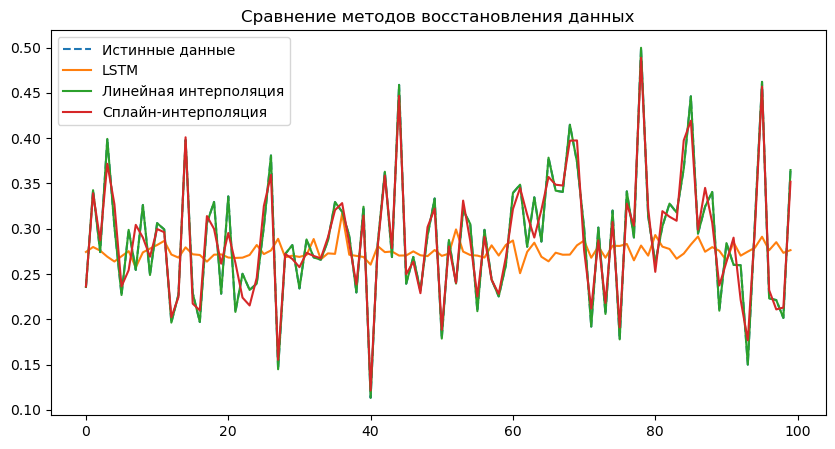

In [6]:
# 5. Тестирование
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred)
Y_test = scaler.inverse_transform(Y_test)

# Оценка
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"LSTM - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# 6. Интерполяция
# Линейная интерполяция
interp = interp1d(np.arange(len(Y_test)), Y_test, kind='linear', axis=0, fill_value="extrapolate")
Y_interp = interp(np.arange(len(Y_test)))

# Сплайновая интерполяция
spline_interp = UnivariateSpline(np.arange(len(Y_test)), Y_test[:, 0], s=1)
Y_spline = spline_interp(np.arange(len(Y_test)))

# 7. Визуализация
plt.figure(figsize=(10, 5))
plt.plot(Y_test[:100, 0], label='Истинные данные', linestyle='dashed')
plt.plot(Y_pred[:100, 0], label='LSTM')
plt.plot(Y_interp[:100, 0], label='Линейная интерполяция')
plt.plot(Y_spline[:100], label='Сплайн-интерполяция')
plt.legend()
plt.title('Сравнение методов восстановления данных')
plt.show()
